<a href="https://colab.research.google.com/github/serrve1/ubion_project1/blob/main/%EA%B2%BD%EA%B8%B0%EA%B5%AD%EB%A9%B4%EB%B3%84MVO%EB%AA%A8%EB%8D%B8%EA%B0%80%EC%A4%91%EC%B9%98(2%EA%B5%AD%EB%A9%B4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # # 한글 폰트 설정 => 런타임 다시 시작 후 실행
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# !pip install html_table_parser# 한글 나눔 폰트

In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 나눔 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 폰트 매니저에 경로 등록
fontprop = fm.FontProperties(fname=font_path, size=12)

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [32]:
# 세부자산군 예를들어 미국주식이면 S&P, 나스닥, 러셀 등등은 우리가 직접 정할 것, 상관계수가 너무 높아 MVO를 돌리면 코너해 문제 발생
# 대표자산군 5개 가져오기 1. GSCI(원자재) 2. S&P500(미국주식)  3. 코스피(한국주식)4. 미국10년만기채(미국주식)  5. 금
assets = ['원자재','S&P500','코스피','미국중기채', '금']
ticker = ['^SPGSCI', '^GSPC', '^KS11','IEF', "GC=F"]
st = {}
# 데이터 수집 시기를 확인
for i, t in enumerate(ticker):
    data = yf.download(t , '2000-01-01', '2023-12-31')
    st[assets[i]] = data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
원자재 = pd.DataFrame()
US500 = pd.DataFrame()
코스피 = pd.DataFrame()
미국중기채 = pd.DataFrame()
금 = pd.DataFrame()

원자재['원자재'] = st[assets[0]]['Adj Close']
US500['US500'] = st[assets[1]]['Adj Close']
코스피['코스피'] = st[assets[2]]['Adj Close']
미국중기채['미국중기채'] = st[assets[3]]['Adj Close']
금['금'] = st[assets[4]]['Adj Close']

df_asset= pd.concat([원자재, US500, 미국중기채],axis = 1)
df_asset
df_asset.reset_index('Date',inplace = True)
코스피.reset_index('Date',inplace = True)
# 코스피 시차조정 미국의 1월1일 = 한국의 1월 2일, 미국 기준으로 시차 조정
df_asset = pd.merge(df_asset, 코스피, on='Date', how='inner')
df_asset = pd.merge(df_asset, 금,  on='Date', how='inner')
# 코스피,시차조정 미국의 1월1일 = 한국의 1월 2일, 미국 기준으로 시차 조정
df_asset['코스피'] = df_asset['코스피'].shift(-1).fillna(method = 'ffill')
df_asset = df_asset[['Date','원자재','US500','코스피','미국중기채','금']]

In [35]:
# 결측치 확인
df_asset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5558 entries, 0 to 5557
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    5558 non-null   datetime64[ns]
 1   원자재     5558 non-null   float64       
 2   US500   5558 non-null   float64       
 3   코스피     5558 non-null   float64       
 4   미국중기채   5115 non-null   float64       
 5   금       5558 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 304.0 KB


In [36]:
# 결측치 확인
df_asset[df_asset.isnull().any(axis = 1) == True ]

,Date,원자재,US500,코스피,미국중기채,금
0,2000-08-30,244.710007,1502.589966,688.619995,NaN,273.899994
1,2000-08-31,244.399994,1517.680054,692.190002,NaN,278.299988
2,2000-09-01,245.309998,1520.770020,679.239990,NaN,277.000000
3,2000-09-05,248.389999,1507.079956,676.690002,NaN,275.799988
4,2000-09-06,252.610001,1492.250000,656.369995,NaN,274.200012
...,...,...,...,...,...,...
438,2002-07-23,200.350006,797.700012,721.409973,NaN,312.700012
439,2002-07-24,203.250000,843.429993,723.520020,NaN,311.500000
440,2002-07-25,202.080002,838.679993,697.840027,NaN,309.799988
441,2002-07-26,200.850006,852.840027,700.349976,NaN,303.399994


In [37]:
# 미국 중기채 결측치를 제거하는 이유 : 2000.1.1~2002.7.29까지인데 이는 3국면, 1국면의 일부분임
# 사실 많은 데이터가 제거되지만 그럼에도 불구하고 이 날짜들을 제거
df_asset = df_asset[df_asset.isnull().any(axis = 1) == False ]

###군집화를 통해 나누어진 국면들
- 0국면 : 2014-12-31 ~ 2019-12-31
- 1국면 : 2001-01-31 ~ 2005-02-28
- 2국면 : 2009-05-31 ~ 2014-11-30
- 3국면 : 2000-01-31 ~ 2000.12~31,
- 3국면-2 : 2005-03-31 ~ 2007-10-31
- 4국면 : 2007-11-30 ~ 2009-04-30

In [38]:
df_asset

,Date,원자재,US500,코스피,미국중기채,금
443,2002-07-30,203.589996,902.780029,717.989990,44.238728,303.700012
444,2002-07-31,203.399994,911.619995,707.799988,44.644489,303.200012
445,2002-08-01,200.289993,884.659973,700.679993,44.828449,304.000000
446,2002-08-02,201.649994,864.239990,675.760010,45.174690,307.000000
447,2002-08-05,199.169998,834.599976,673.780029,45.401917,307.799988
...,...,...,...,...,...,...
5553,2023-12-21,543.789978,4746.750000,2599.510010,96.044441,2039.099976
5554,2023-12-22,543.729980,4754.629883,2602.590088,95.954666,2057.100098
5555,2023-12-26,551.150024,4774.750000,2613.500000,96.014519,2058.199951
5556,2023-12-27,547.059998,4781.580078,2655.280029,96.762680,2081.899902


In [39]:
df_asset = df_asset.loc[df_asset['Date'].dt.year < 2020]
# 국면 자르기
# 0국면
df_asset_0국면 = df_asset.loc[df_asset['Date'].dt.year > 2014]
# 1국면
df_asset_1국면 = df_asset.loc[(df_asset['Date'].dt.year > 2000) & (df_asset['Date'].dt.year <= 2005)]
df_asset_1국면 = df_asset_1국면.iloc[17:-205]
# 2국면
df_asset_2국면 = df_asset.loc[(df_asset['Date'].dt.year > 2008) & (df_asset['Date'].dt.year <= 2014)]
df_asset_2국면 = df_asset_2국면.iloc[98:-21]
# 3국면-2만 MVO
df_asset_3국면 = df_asset.loc[(df_asset['Date'].dt.year >= 2005) & (df_asset['Date'].dt.year <= 2007)]
df_asset_3국면 = df_asset_3국면.iloc[56:-40]
# 4국면
df_asset_4국면 = df_asset.loc[(df_asset['Date'].dt.year >= 2007) & (df_asset['Date'].dt.year <= 2009)]
df_asset_4국면 = df_asset_4국면.iloc[219:-166]


df_asset_0국면.set_index('Date',inplace = True)
df_asset_1국면.set_index('Date',inplace = True)
df_asset_2국면.set_index('Date',inplace = True)
df_asset_3국면.set_index('Date',inplace = True)
df_asset_4국면.set_index('Date',inplace = True)

In [40]:
# 날짜를 기반으로 cluster 설정
df_asset['cluster'] = df_asset['Date'].apply(lambda x: 3 if x <= pd.to_datetime('2000-12-31') else
                                         1 if x <= pd.to_datetime('2005-02-28') else
                                         3 if x <= pd.to_datetime('2007-10-31') else
                                         4 if x <= pd.to_datetime('2009-04-30') else
                                         2 if x <= pd.to_datetime('2014-11-30') else 0)

<ipython-input-40-2416a3023837>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_asset['cluster'] = df_asset['Date'].apply(lambda x: 3 if x <= pd.to_datetime('2000-12-31') else


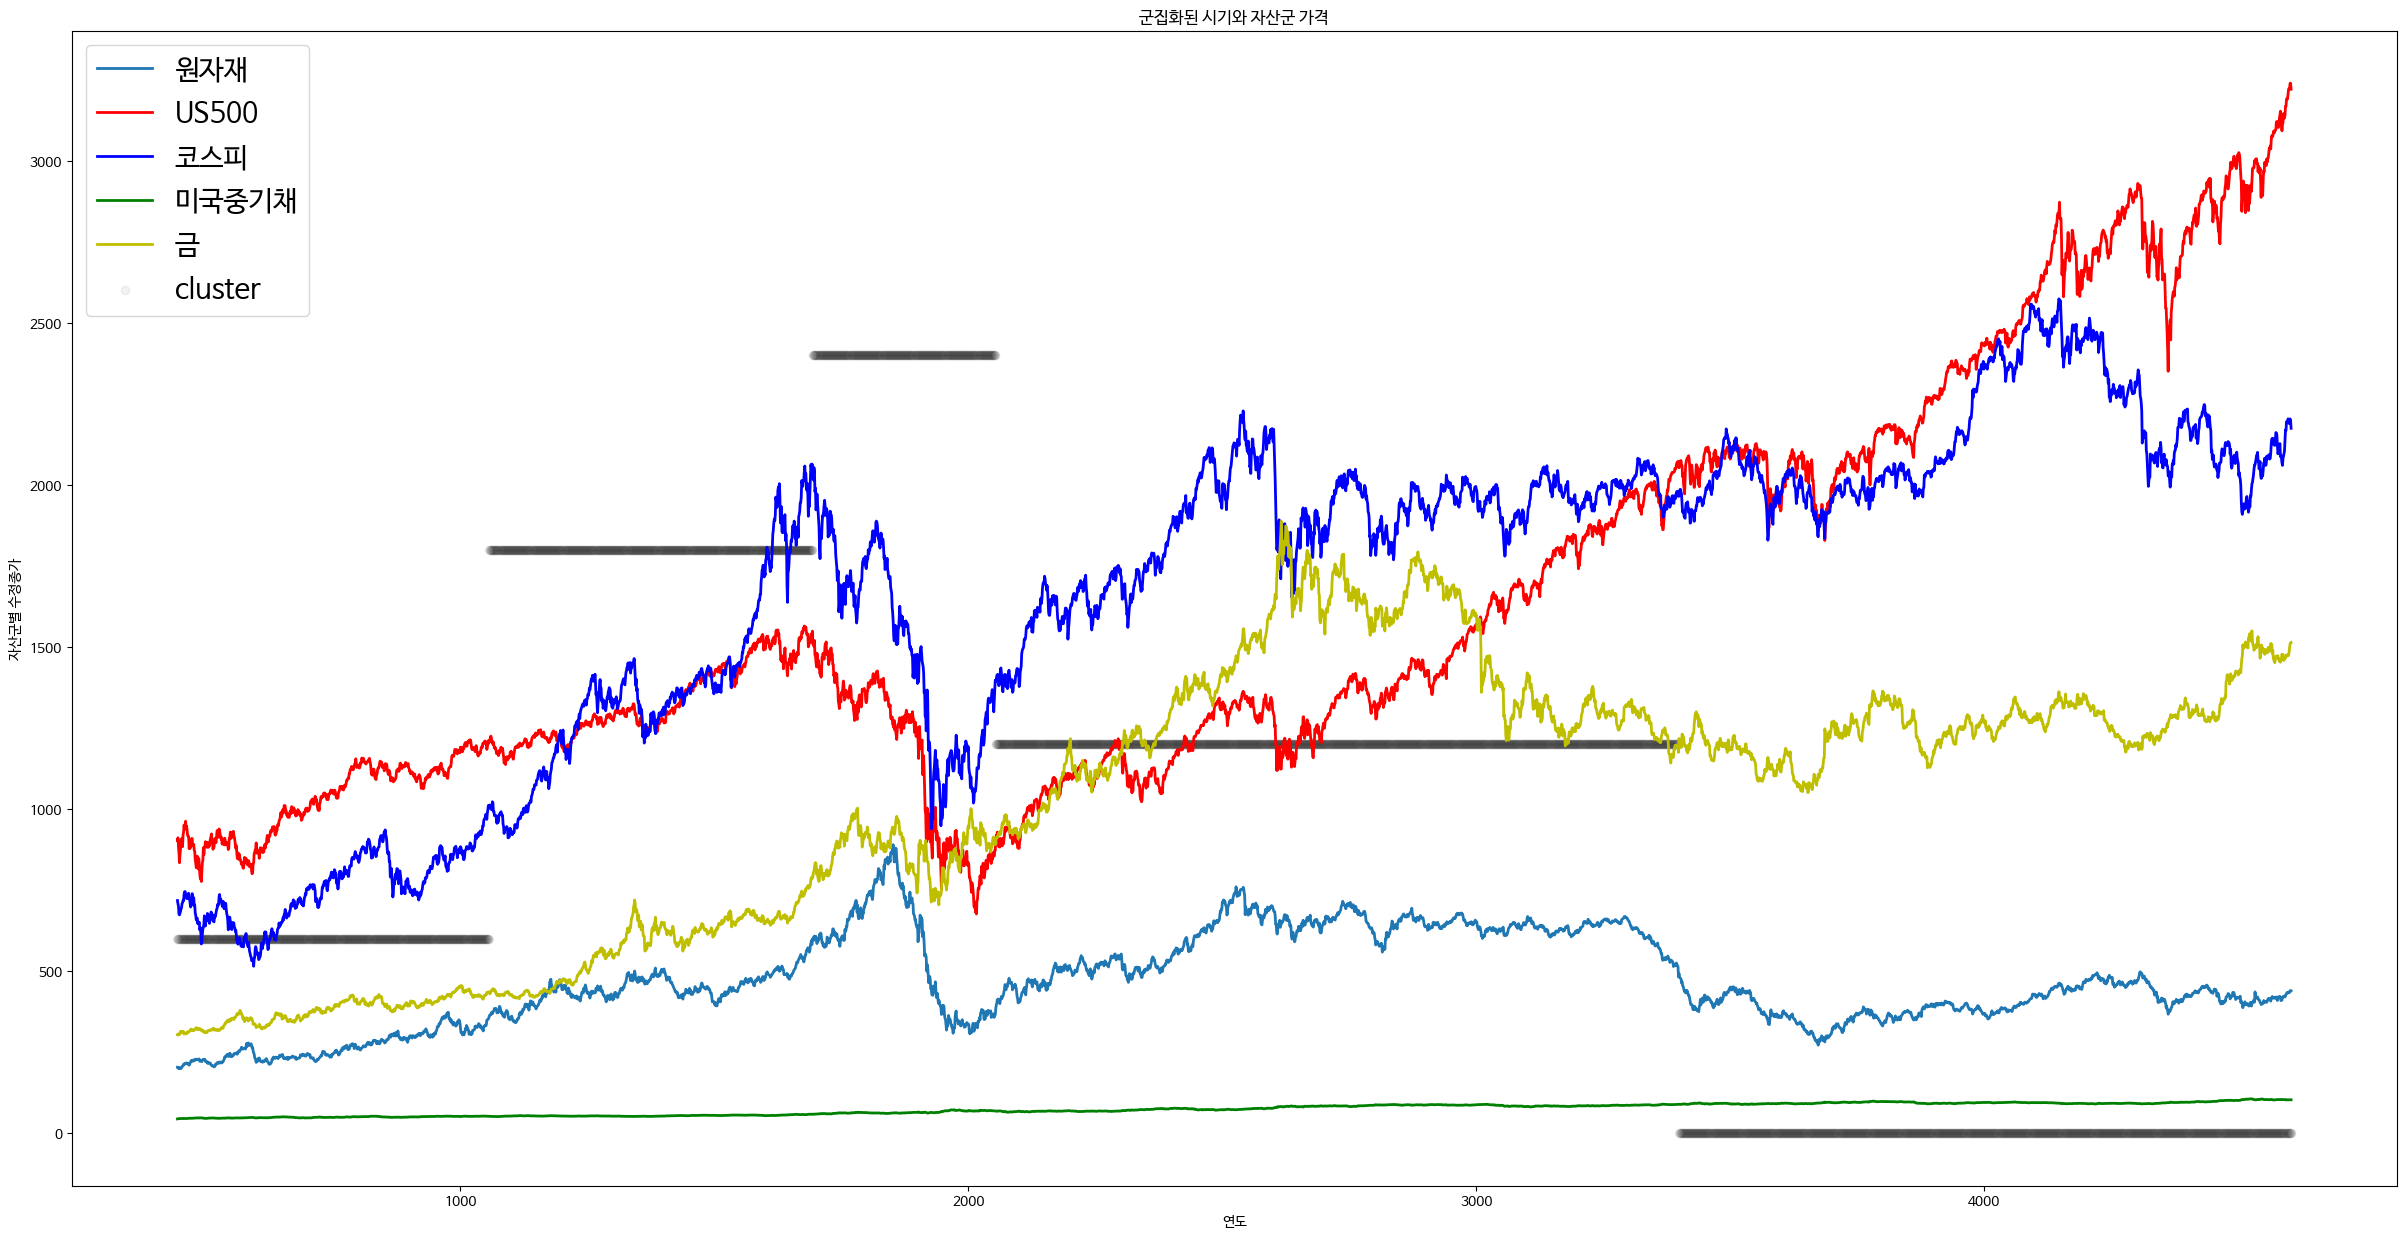

In [41]:
# 자산군 수익률과 경제국면 클러스터 시각화
plt.figure(figsize=(30, 15))
plt.rc('font', family='NanumBarunGothic')
plt.plot(df_asset['원자재'],label='원자재', linewidth=2)
plt.plot(df_asset['US500'],'r',label='US500',linewidth=2)
plt.plot(df_asset['코스피'],'b',label='코스피',linewidth=2)
plt.plot(df_asset['미국중기채'],'g',label='미국중기채',linewidth=2)
plt.plot(df_asset['금'],'y',label='금',linewidth=2)

plt.scatter(df_asset.index, df_asset['cluster']*600, label='cluster', alpha = 0.05, color='black')
plt.xlabel('연도')
plt.ylabel('자산군별 수정종가')
plt.title('군집화된 시기와 자산군 가격')# 그래프 이름 정의
plt.legend(loc='upper left', fontsize=20)#  plt.legend(‘위치') 정의
plt.show()

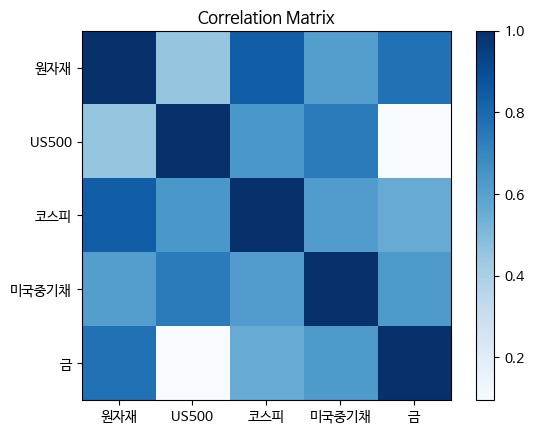

In [42]:
# 2국면 상관관계
import matplotlib.pyplot as plt
# 상관행렬 계산
Corr = df_asset_2국면.corr()
plt.figure()
plt.rc('font', family='NanumBarunGothic')
plt.title('Correlation Matrix')
plt.imshow(Corr, cmap=plt.cm.Blues)
plt.xticks(range(len(df_asset_2국면.columns)),df_asset_2국면.columns)
plt.yticks(range(len(df_asset_2국면.columns)),df_asset_2국면.columns)
plt.colorbar()
plt.show()

In [43]:
Corr

,원자재,US500,코스피,미국중기채,금
원자재,1.000000,0.452684,0.839786,0.610288,0.772590
US500,0.452684,1.000000,0.637104,0.735334,0.094904
코스피,0.839786,0.637104,1.000000,0.615879,0.557999
미국중기채,0.610288,0.735334,0.615879,1.000000,0.626036
금,0.772590,0.094904,0.557999,0.626036,1.000000


In [44]:
daily_ret = df_asset_2국면.pct_change()
daily_ret = daily_ret.fillna(0)
# 252는 평균 개장일 (미국기준)
annual_ret = daily_ret.mean() * 252
daily_cov = daily_ret.cov()
annual_cov = daily_cov * 252

In [45]:
df_asset_2국면.columns

Index(['원자재', 'US500', '코스피', '미국중기채', '금'], dtype='object')

In [46]:
#!pip install riskfolio-lib

In [47]:
# 최대 샤프 지수 포트폴리오
import riskfolio as rp

# 입력값 계산
method_mu = 'hist'
#포트폴리오 객체 생성
port = rp.Portfolio(returns=daily_ret)

#입력값 계산
method_mu = 'hist' #역사적 데이터 바탕으로 기대수익률 추정
method_cov = 'hist' #역사적 데이터 바탕으로 분산, 공분산 행렬 추정

#객체에 수익률 및 분산, 공분산 입력
port.assets_stats(method_mu=method_mu, method_cov=method_cov)

model = 'Classic' #모델 입력, Class:역사적 데이터, BL: 블랙 리터만, FM(팩터모형)
rm = 'MV' #위험측정방법 MV: 표준편차를 의미
obj = 'Sharpe' #목적함수, MinRisk(최소분산) MaxRet(최대수익률), utility(효용), Sharpe(샤프지수)
hist = True #역사적 데이터 사용
rf = 0 #무위험수익률
l = 0 #위험회피계수

#최적화
w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

가중치 = round(w.T, 4)
가중치

,원자재,US500,코스피,미국중기채,금
weights,0.0,0.306,0.0008,0.6932,0.0


In [48]:
points = 100
frontier = port.efficient_frontier(model = model,rm=rm, points = points, rf = rf, hist =hist)
frontier.T.head().round(4)

,원자재,US500,코스피,미국중기채,금
0,0.0419,0.1900,0.0411,0.7260,0.001
1,0.0000,0.2649,0.0209,0.7141,0.000
2,0.0000,0.2973,0.0051,0.6976,0.000
3,0.0000,0.3190,0.0000,0.6810,0.000
4,0.0000,0.3357,0.0000,0.6643,0.000


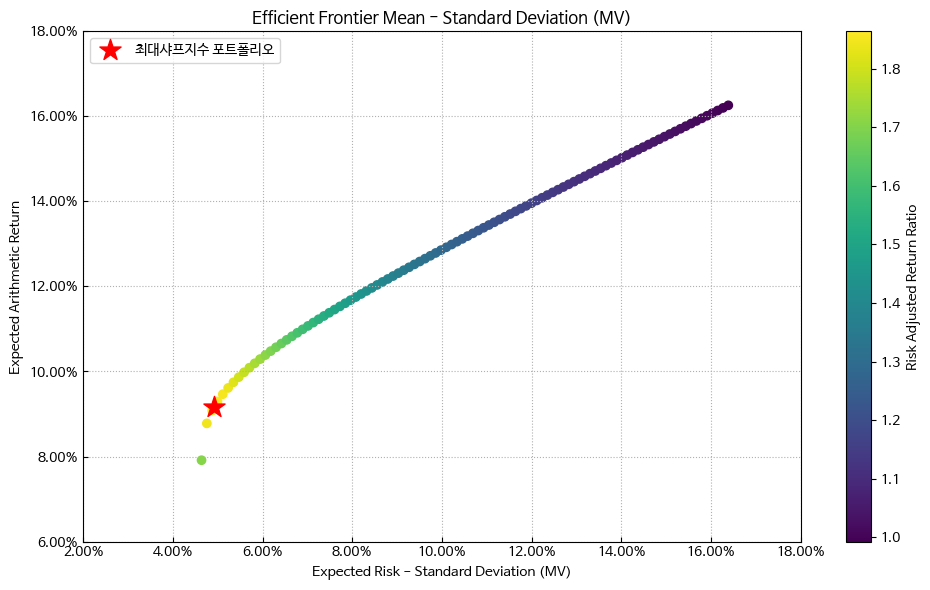

In [49]:
label = '최대샤프지수 포트폴리오'
mu = port.mu
cov =port.cov
returns = port.returns
ax = rp.plot_frontier(w_frontier= frontier, mu = mu, cov = cov, returns= returns, rm = rm,
                      rf =rf, alpha =0.05, cmap = 'viridis', w=w, label = label, marker = '*',
                      s =16, c ='r', height = 6, width = 10, ax = None
                      )

In [50]:
# 포트폴리오의 연간 수익률 계산
w = np.array(가중치)
portfolio_annual_return = np.dot(w, annual_ret)
print("Portfolio Annual Return:", portfolio_annual_return)

Portfolio Annual Return: [0.09164134]


In [51]:
# 포트폴리오의 연간 분산 계산
w = w.flatten()
portfolio_annual_variance = np.dot(np.dot(w, annual_cov), w)
portfolio_annual_stddev = np.sqrt(portfolio_annual_variance)
print("portfolio_annual_stddev :", portfolio_annual_stddev )

portfolio_annual_stddev : 0.0491402305560319


In [52]:
가중치

,원자재,US500,코스피,미국중기채,금
weights,0.0,0.306,0.0008,0.6932,0.0


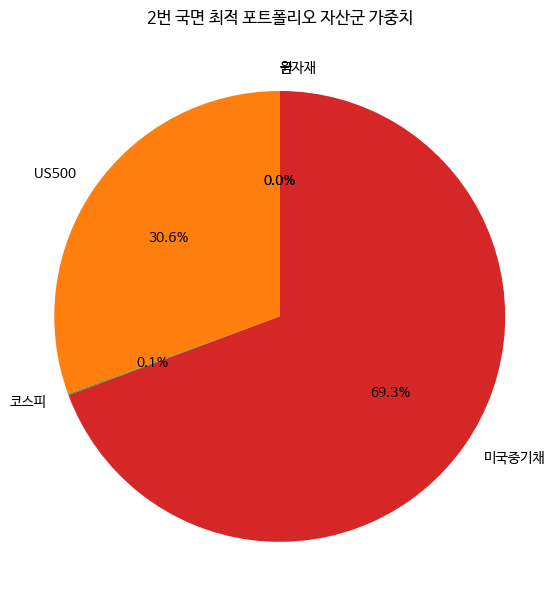

In [53]:
# 가중치 컬럼 선택
가중치 = 가중치.iloc[0]
# 파이 차트 그리기
plt.pie(가중치 , labels = 가중치.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # 원형을 유지하기 위해 설정
plt.title('2번 국면 최적 포트폴리오 자산군 가중치')
plt.subplots_adjust(top=1.3)
plt.show()

In [54]:
# 최소 최대 투자 비중 제약 조건
# 최소조건 5%,  최대 조건 50%
asset_classes = {
    'Asset' : ['원자재','US500','코스피','미국중기채','금'] ,
    'Class' : ['원자재','미국주식','한국주식','미국채권','금'],
}
asset_classes = pd.DataFrame(asset_classes)
asset_classes

,Asset,Class
0,원자재,원자재
1,US500,미국주식
2,코스피,한국주식
3,미국중기채,미국채권
4,금,금


In [55]:
# 최대 가중치 50%, 최소가중치 5%
constraints = {'Disable': [False, False],
              'Type': ['All Assets', 'All Assets'],
              'Set' : ['', ''],
              'Position' : ['', ''],
              'Sign' : ['>=', '<='],
              'Weight' : [0.05, 0.5],
              'Type Relative' : ['',''],
              'Relative Set' : ['', ''],
              'Relative' : ['', ''],
              'Factor' : ['','']}
constraints = pd.DataFrame(constraints)
constraints

,Disable,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
0,False,All Assets,,,>=,0.05,,,,
1,False,All Assets,,,<=,0.50,,,,


In [56]:
A, B = rp.assets_constraints(constraints, asset_classes)
port.ainequality = A
port.binequality = B

w = port.optimization(model = model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
조정한가중치 = w.T

In [57]:
# 포트폴리오의 연간 수익률 계산
w = np.array(조정한가중치)
portfolio_annual_return = np.dot(w, annual_ret)
print("Portfolio Annual Return:", portfolio_annual_return)

Portfolio Annual Return: [0.09494605]


In [58]:
# 포트폴리오의 연간 분산 계산
w = w.flatten()
portfolio_annual_variance = np.dot(np.dot(w, annual_cov), w)
portfolio_annual_stddev = np.sqrt(portfolio_annual_variance)
print("portfolio_annual_stddev :", portfolio_annual_stddev )

portfolio_annual_stddev : 0.06102254678959598


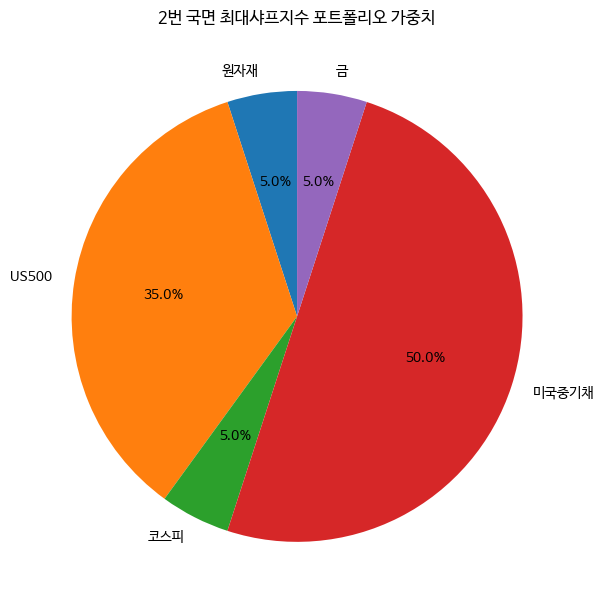

In [59]:
# 가중치 컬럼 선택
조정한가중치 = 조정한가중치.iloc[0]
# 파이 차트 그리기
plt.pie(조정한가중치 , labels = 조정한가중치.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # 원형을 유지하기 위해 설정
plt.title('2번 국면 최대샤프지수 포트폴리오 가중치')
plt.subplots_adjust(top=1.3)
plt.show()